## Prima feature selection poi non piú usata
Avevo cercato di trovare le feature piú importanti attraverso la libreria `sklearn` e la funzione `SelectKBest` con il metodo `f_classif`. Tuttavia, dopo aver eseguito questa selezione, ho deciso di non utilizzare piú le feature selezionate per il mio modello.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [17]:
df= pd.read_csv('data/UNSW-NB15_processed.csv')
df

,srcip,dstip,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label,BytesPerPkt,PktPerSec,RatioOutIn,IPSrcType,IPDstType,SrcPortWellKnown,SrcPortRegistered,SrcPortPrivate,DstPortWellKnown,DstPortRegistered,DstPortPrivate
0,175.45.176.2,149.171.126.16,FIN,0.240139,918,25552,62,252,2,10,http,28050.421880,815794.187500,12,24,255,255,1708297952,1939490744,77,1065,1,12026,1170.481668,1144.383360,1421927416,1421927416,21.830818,9.570304,0.051475,0.006528,0.044947,0,1,3,2,2,1,1,1,1,Exploits,1,735.277778,149.913175,0.035927,0,0,0,1,0,1,0,0
1,175.45.176.0,149.171.126.16,FIN,2.390390,1362,268,254,252,6,1,http,4233.619141,749.668518,14,6,255,255,3897219059,2466816006,97,45,1,0,18786.711400,941.724938,1421927414,1421927416,183.579303,474.259406,0.066088,0.017959,0.048129,0,1,5,2,2,1,1,1,1,Reconnaissance,1,81.500000,8.366836,5.082090,0,0,0,1,0,1,0,0
2,175.45.176.2,149.171.126.16,FIN,0.175190,8168,268,254,252,4,1,-,346366.812500,10228.894530,14,6,255,255,2505143795,3592239707,583,45,0,0,774.788316,47.765387,1421927417,1421927417,11.837692,33.287000,0.054878,0.008744,0.046134,0,1,1,1,1,1,1,1,1,Exploits,1,421.800000,114.161767,30.477612,0,0,0,1,0,0,1,0
3,175.45.176.2,149.171.126.10,FIN,0.190600,844,268,254,252,2,1,http,31899.267580,9401.888672,10,6,255,255,3006332195,1452987536,84,45,1,0,996.632407,59.532129,1421927418,1421927418,18.573778,36.845602,0.050675,0.006354,0.044321,0,1,3,1,1,1,1,1,1,Exploits,1,69.500000,83.945435,3.149254,0,0,0,1,0,1,0,0
4,175.45.176.0,149.171.126.15,FIN,0.177449,1214,268,254,252,2,1,http,49276.128910,10098.675780,10,6,255,255,366102997,2277661750,121,45,1,0,1020.236764,62.002961,1421927419,1421927419,19.203667,34.071199,0.051980,0.007076,0.044904,0,1,5,2,1,1,1,1,1,DoS,1,92.625000,90.166752,4.529851,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138455,59.166.0.4,149.171.126.2,CON,1.616038,1626,60216,31,29,2,21,-,7687.937988,291319.875000,22,44,255,255,3559312905,1591848767,74,1369,1,28698,4791.249452,2883.850201,1424262067,1424262069,76.946571,37.571442,0.000579,0.000463,0.000116,0,0,2,2,2,2,2,2,2,Normal,0,937.000000,40.840624,0.027003,0,0,0,0,1,1,0,0
1138456,59.166.0.5,149.171.126.7,FIN,0.087306,320,1828,31,29,1,2,ftp-data,24465.671880,146610.765600,6,8,255,255,4035116044,222196311,53,229,0,0,1221.136547,30.096029,1424262068,1424262069,17.394400,12.405143,0.000608,0.000468,0.000140,0,0,1,2,3,3,1,1,3,Normal,0,153.428571,160.355531,0.175055,0,0,0,1,0,0,1,0
1138457,59.166.0.7,149.171.126.4,CON,0.365058,456,346,31,29,2,2,ftp,8743.816406,6333.240234,8,6,255,255,1529727621,185369967,57,58,0,0,3961.093354,129.038367,1424262068,1424262069,51.976999,72.915602,0.000609,0.000477,0.000132,0,0,2,2,2,2,2,2,2,Normal,0,57.285714,38.350070,1.317919,0,0,0,1,0,1,0,0
1138458,59.166.0.9,149.171.126.0,CON,2.200934,3498,166054,31,29,2,57,http,12496.513670,598375.062500,58,116,255,255,1289728069,3436097151,60,1432,1,79745,2868.893137,1951.035944,1424262067,1424262069,38.609700,19.133826,0.000680,0.000541,0.000139,0,0,1,1,2,4,2,2,2,Normal,0,974.436782,79.057346,0.021065,0,0,0,1,0,1,0,0


In [ ]:
features = ['IPSrcType', 'IPDstType', 'SrcPortWellKnown', 'DstPortWellKnown', 'SrcPortRegistered', 'DstPortRegistered', 'SrcPortPrivate', 'DstPortPrivate','dur', 
'sbytes', 'dbytes', 'BytesPerPkt', 'PktPerSec', 'RatioOutIn', 'state', 'service', 'attack_cat','sttl', 'dttl','tcprtt','ct_state_ttl', 'dmeansz','ct_srv_dst', 'ct_dst_src_ltm', 'Label']
partial_df = df[features]
selected_features = [
    # IP/porta info
    'IPSrcType', 'IPDstType', 
    'SrcPortWellKnown', 'DstPortWellKnown', 
    'SrcPortRegistered', 'DstPortRegistered', 
    'SrcPortPrivate', 'DstPortPrivate',

    # Quantità / statistiche generali
    'dur', 'sbytes', 'dbytes', 'BytesPerPkt', 'PktPerSec', 'RatioOutIn',
    'Dload', 'Dintpkt', 'res_bdy_len',  # ← nuovo

    # Stato pacchetti
    'synack', 'ackdat',  # ← nuovo

    # TTL & timing
    'sttl', 'dttl', 'tcprtt',

    # Connessioni aggregate
    'ct_state_ttl', 'ct_srv_dst', 'ct_srv_src', 'ct_dst_src_ltm', 'dmeansz',

    # Categorical
    'state', 'service',

    # Target (non come feature ovviamente)
    'attack_cat', 'Label'
]

In [21]:

#one hot encoding per le features categoriche
df = pd.get_dummies(df, columns=['state', 'service'])
df = df.drop(['attack_cat'], axis=1)
partial_df = pd.get_dummies(partial_df, columns=['state', 'service'])
partial_df = partial_df.drop(['attack_cat'], axis=1)
df


,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,Label,BytesPerPkt,PktPerSec,RatioOutIn,IPSrcType,IPDstType,SrcPortWellKnown,SrcPortRegistered,SrcPortPrivate,DstPortWellKnown,DstPortRegistered,DstPortPrivate,state_ACC,state_CLO,state_CON,state_FIN,state_REQ,state_RST,service_-,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_smtp,service_ssh,service_ssl
0,0.240139,918,25552,62,252,2,10,28050.421880,815794.187500,12,24,255,255,1708297952,1939490744,77,1065,1,12026,1170.481668,1144.383360,1421927416,1421927416,21.830818,9.570304,0.051475,0.006528,0.044947,0,1,3,2,2,1,1,1,1,1,735.277778,149.913175,0.035927,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1,2.390390,1362,268,254,252,6,1,4233.619141,749.668518,14,6,255,255,3897219059,2466816006,97,45,1,0,18786.711400,941.724938,1421927414,1421927416,183.579303,474.259406,0.066088,0.017959,0.048129,0,1,5,2,2,1,1,1,1,1,81.500000,8.366836,5.082090,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0.175190,8168,268,254,252,4,1,346366.812500,10228.894530,14,6,255,255,2505143795,3592239707,583,45,0,0,774.788316,47.765387,1421927417,1421927417,11.837692,33.287000,0.054878,0.008744,0.046134,0,1,1,1,1,1,1,1,1,1,421.800000,114.161767,30.477612,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,0.190600,844,268,254,252,2,1,31899.267580,9401.888672,10,6,255,255,3006332195,1452987536,84,45,1,0,996.632407,59.532129,1421927418,1421927418,18.573778,36.845602,0.050675,0.006354,0.044321,0,1,3,1,1,1,1,1,1,1,69.500000,83.945435,3.149254,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,0.177449,1214,268,254,252,2,1,49276.128910,10098.675780,10,6,255,255,366102997,2277661750,121,45,1,0,1020.236764,62.002961,1421927419,1421927419,19.203667,34.071199,0.051980,0.007076,0.044904,0,1,5,2,1,1,1,1,1,1,92.625000,90.166752,4.529851,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138455,1.616038,1626,60216,31,29,2,21,7687.937988,291319.875000,22,44,255,255,3559312905,1591848767,74,1369,1,28698,4791.249452,2883.850201,1424262067,1424262069,76.946571,37.571442,0.000579,0.000463,0.000116,0,0,2,2,2,2,2,2,2,0,937.000000,40.840624,0.027003,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1138456,0.087306,320,1828,31,29,1,2,24465.671880,146610.765600,6,8,255,255,4035116044,222196311,53,229,0,0,1221.136547,30.096029,1424262068,1424262069,17.394400,12.405143,0.000608,0.000468,0.000140,0,0,1,2,3,3,1,1,3,0,153.428571,160.355531,0.175055,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1138457,0.365058,456,346,31,29,2,2,8743.816406,6333.240234,8,6,255,255,1529727621,185369967,57,58,0,0,3961.093354,129.038367,1424262068,1424262069,51.976999,72.915602,0.000609,0.000477,0.000132,0,0,2,2,2,2,2,2,2,0,57.285714,38.350070,1.317919,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1138458,2.200934,3498,166054,31,29,2,57,12496.513670,598375.062500,58,116,255,255,1289728069,3436097151,60,1432,1,79745,2868.893137,1951.035944,1424262067,1424262069,38.609700,19.133826,0.000680,0.000541,0.000139,0,0,1,1,2,4,2,2,2,0,974.436782,79.057346,0.021065,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


In [22]:
corr_matrix = df.corr(numeric_only=True).abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

corr_matrix_partial = partial_df.corr(numeric_only=True).abs()
upper_tri_partial = corr_matrix_partial.where(np.triu(np.ones(corr_matrix_partial.shape), k=1).astype(bool))

# Trova colonne da rimuovere perché troppo simili ad altre (corr > 0.95)
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
to_drop_partial = [column for column in upper_tri_partial.columns if any(upper_tri_partial[column] > 0.95)]
# Stampa le colonne da rimuovere
print("Colonne da rimuovere per alta correlazione:")
print(to_drop)
print("Colonne da rimuovere per alta correlazione (partial_df):")
print(to_drop_partial)

Colonne da rimuovere per alta correlazione:
['Dpkts', 'Ltime', 'Sintpkt', 'SrcPortPrivate', 'state_FIN']
Colonne da rimuovere per alta correlazione (partial_df):
['SrcPortPrivate', 'state_FIN']


In [23]:
X = df.drop('Label', axis=1)
y = df['Label']
X_partial = partial_df.drop('Label', axis=1)
y_partial = partial_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train_partial, X_test_partial, y_train_partial, y_test_partial = train_test_split(X_partial, y_partial, test_size=0.3, random_state=42, stratify=y_partial)

In [24]:

scaler = StandardScaler()
continuous_features = X_train.select_dtypes(include=['float64', 'int64']).columns
continuous_features_partial = X_train_partial.select_dtypes(include=['float64', 'int64']).columns
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled_partial = X_train_partial.copy()
X_test_scaled_partial = X_test_partial.copy()

X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test_scaled[continuous_features] = scaler.transform(X_test[continuous_features])
X_train_scaled_partial[continuous_features_partial] = scaler.fit_transform(X_train_partial[continuous_features_partial])
X_test_scaled_partial[continuous_features_partial] = scaler.transform(X_test_partial[continuous_features_partial])


In [25]:
#Riunisco train e test per fare il cross validation
X = pd.concat([X_train_scaled_partial, X_test_scaled_partial])
y = pd.concat([y_train_partial, y_test_partial])
X

,IPSrcType,IPDstType,SrcPortWellKnown,DstPortWellKnown,SrcPortRegistered,DstPortRegistered,SrcPortPrivate,DstPortPrivate,dur,sbytes,dbytes,BytesPerPkt,PktPerSec,RatioOutIn,sttl,dttl,tcprtt,ct_state_ttl,dmeansz,ct_srv_dst,ct_dst_src_ltm,state_ACC,state_CLO,state_CON,state_FIN,state_REQ,state_RST,service_-,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_smtp,service_ssh,service_ssl
978071,0.0,0.0,-0.024829,-0.679286,-1.695595,0.904615,1.698328,-0.393881,-0.743698,0.137547,-0.666086,-0.690002,1.711546,-0.002064,-0.235126,-0.265761,-0.198329,-0.244463,-0.965085,0.237812,0.357291,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
894128,0.0,0.0,-0.024829,-0.679286,0.589763,0.904615,-0.588815,-0.393881,-0.129085,0.412498,-0.670559,-1.013749,-0.797024,0.095034,-0.235126,-0.265761,-0.195852,-0.244463,-1.095384,0.237812,-0.149232,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
839112,0.0,0.0,-0.024829,-0.679286,0.589763,0.904615,-0.588815,-0.393881,-0.697133,-0.187626,0.159264,0.217690,0.400882,-0.263787,-0.235126,-0.265761,-0.196581,-0.244463,0.457916,0.237812,-0.655756,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
329903,0.0,0.0,-0.024829,-0.679286,0.589763,0.904615,-0.588815,-0.393881,-0.681346,0.242556,1.665309,1.087235,0.923559,-0.271070,-0.235126,-0.265761,-0.197892,-0.244463,1.387153,0.237812,-0.655756,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
184598,0.0,0.0,-0.024829,-0.679286,0.589763,0.904615,-0.588815,-0.393881,-0.718201,-0.130809,0.367977,0.432181,1.298881,-0.266023,-0.235126,-0.265761,-0.196999,-0.244463,0.680796,1.517082,-0.655756,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662972,0.0,0.0,-0.024829,1.472134,0.589763,-1.105443,-0.588815,-0.393881,1.243751,-0.405253,-0.358087,0.593785,-0.868217,-0.253716,-0.235126,-0.265761,-0.198675,-0.244463,0.505921,-1.041458,-0.149232,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
990917,0.0,0.0,-0.024829,-0.679286,0.589763,0.904615,-0.588815,-0.393881,-0.635536,-0.335754,-0.671997,-1.225356,-0.529244,-0.130234,-0.235126,-0.265761,-0.199495,-0.244463,-1.102242,-0.529750,1.370337,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
54438,0.0,0.0,-0.024829,-0.679286,-1.695595,0.904615,1.698328,-0.393881,-0.575696,0.400830,2.547850,1.550733,-0.007867,-0.273067,-0.235126,-0.265761,-0.198894,-0.244463,1.874059,-0.529750,-0.655756,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
246183,0.0,0.0,-0.024829,-0.679286,0.589763,0.904615,-0.588815,-0.393881,-0.700769,-0.134867,0.402723,0.443760,0.651239,-0.266648,-0.235126,-0.265761,-0.184231,-0.244463,0.656793,0.749520,1.876860,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [26]:
# #Riunisco i dataset e li salvo
# X_train_scaled['label'] = y_train
# X_test_scaled['label'] = y_test
# X_train_scaled.to_csv('./data/train_processed.csv', index=False)
# X_test_scaled.to_csv('./data/test_processed.csv', index=False)
#rimuovo colonna attack_cat]

X_train = X_train_scaled.to_numpy(dtype=np.float32)
X_test= X_test_scaled.to_numpy(dtype=np.float32)
y_train= y_train.to_numpy(dtype=np.int32)
y_test= y_test.to_numpy(dtype=np.int32)
X_train_cp = cp.array(X_train)
X_test_cp = cp.array(X_test)
y_train_cp = cp.array(y_train)

X_train_partial = X_train_scaled_partial.to_numpy(dtype=np.float32)
X_test_partial= X_test_scaled_partial.to_numpy(dtype=np.float32)
y_train_partial= y_train_partial.to_numpy(dtype=np.int32)
y_test_partial= y_test_partial.to_numpy(dtype=np.int32)
X_train_partial_cp = cp.array(X_train_partial)
X_test_partial_cp = cp.array(X_test_partial)
y_train_partial_cp = cp.array(y_train_partial)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# skf = StratifiedKFold(n_splits=5)
# model = RandomForestClassifier()

# accuracies = []
# precisions = []
# recalls = []
# f1s = []

# for train_index, test_index in skf.split(X, y):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
    
#     accuracies.append(accuracy_score(y_test, y_pred))
#     precisions.append(precision_score(y_test, y_pred))
#     recalls.append(recall_score(y_test, y_pred))
#     f1s.append(f1_score(y_test, y_pred))

# # Media finale
# print("Average Accuracy:", np.mean(accuracies))
# print("Average Precision:", np.mean(precisions))
# print("Average Recall:", np.mean(recalls))
# print("Average F1 Score:", np.mean(f1s))


model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

model_partial = RandomForestClassifier(random_state=0)
model_partial.fit(X_train_partial, y_train_partial)

importances = model.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

importances_partial = model_partial.feature_importances_
feat_importance_partial = pd.Series(importances_partial, index=X_partial.columns).sort_values(ascending=False)



Average Accuracy: 0.9921780299703109
Average Precision: 0.9198708740796206
Average Recall: 0.8969789441562405
Average F1 Score: 0.9082787425289348


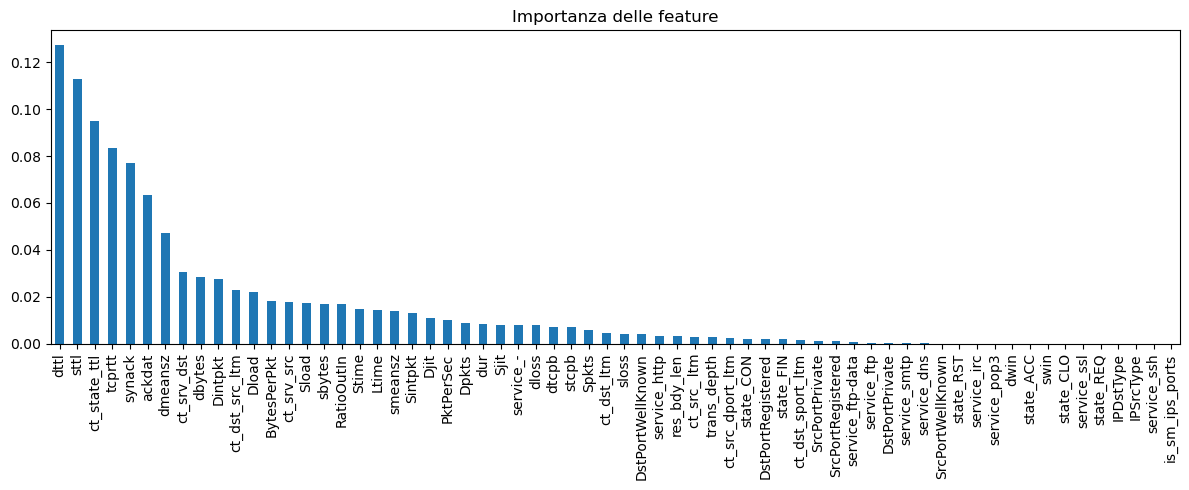

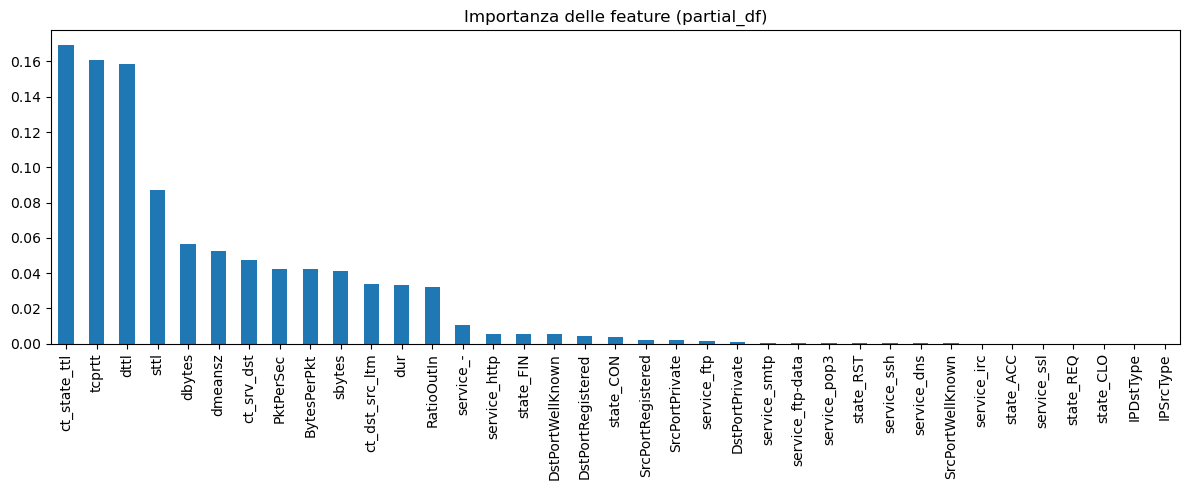

Accuratezza: 0.9936727391973953
Accuratezza (partial_df): 0.9919745387043316
F1 Score: 0.9257821890991517
F1 Score (partial_df): 0.9060174867135264
              precision    recall  f1-score   support

      Benign    0.99612   0.99727   0.99670    326792
   Malicious    0.93786   0.91401   0.92578     14746

    accuracy                        0.99367    341538
   macro avg    0.96699   0.95564   0.96124    341538
weighted avg    0.99361   0.99367   0.99363    341538

              precision    recall  f1-score   support

      Benign    0.99531   0.99631   0.99581    326792
   Malicious    0.91629   0.89597   0.90602     14746

    accuracy                        0.99197    341538
   macro avg    0.95580   0.94614   0.95091    341538
weighted avg    0.99190   0.99197   0.99193    341538



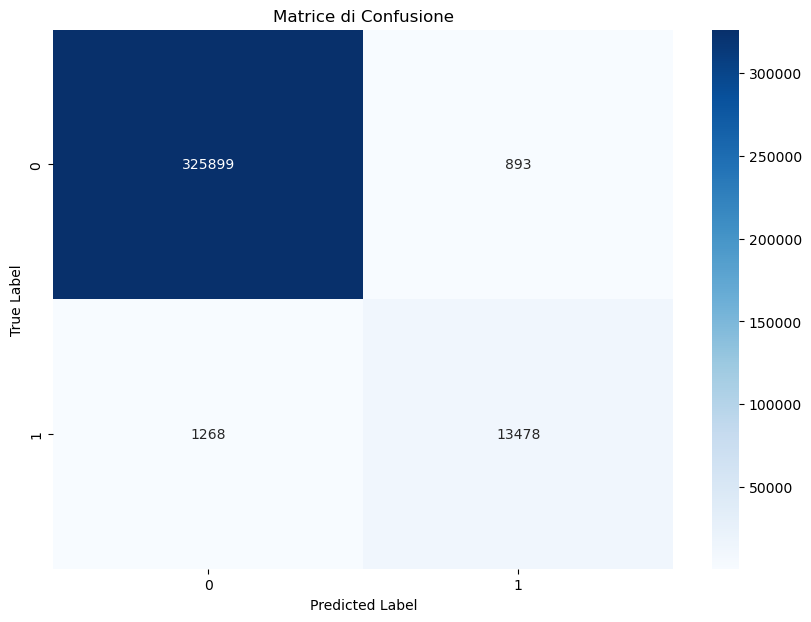

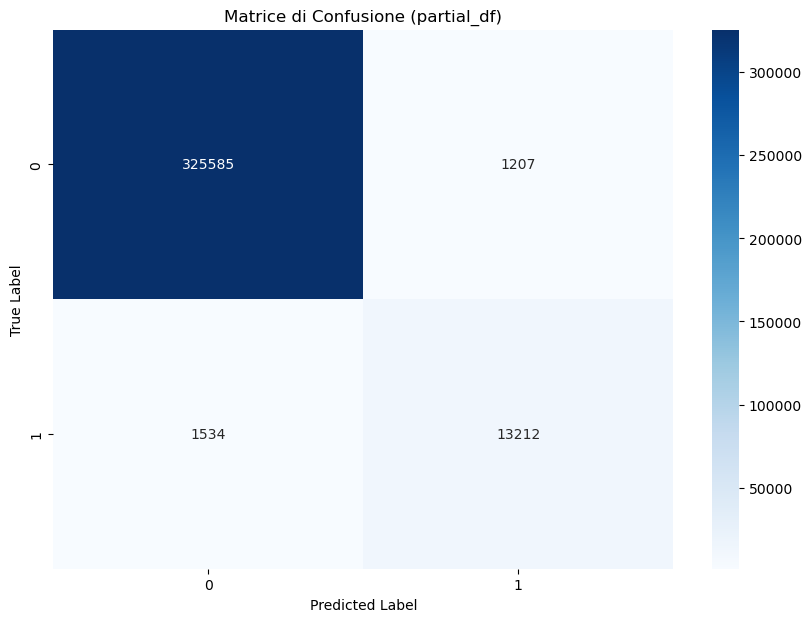

In [28]:
# Plot
feat_importance.plot(kind='bar', figsize=(12,5), title='Importanza delle feature')
plt.tight_layout()
plt.show()

feat_importance_partial.plot(kind='bar', figsize=(12,5), title='Importanza delle feature (partial_df)')
plt.tight_layout()
plt.show()
# Mostra le feature con importanza molto bassa
# print(feat_importance[feat_importance < 0.01])

# Calcola l'accuratezza
y_pred = model.predict(X_test)

y_pred_partial = model_partial.predict(X_test_partial)


accuracy = accuracy_score(y_test, y_pred)
accuracy_partial = accuracy_score(y_test_partial, y_pred_partial)
print("Accuratezza:", accuracy)
print("Accuratezza (partial_df):", accuracy_partial)
f1 = f1_score(y_test, y_pred)
f1_partial = f1_score(y_test_partial, y_pred_partial)
print("F1 Score:", f1)
print("F1 Score (partial_df):", f1_partial)

report = classification_report(y_test, y_pred, digits=5, target_names=['Benign', 'Malicious'])
print(report)
report_partial = classification_report(y_test_partial, y_pred_partial, digits=5, target_names=['Benign', 'Malicious'])
print(report_partial)
# Matrice di confusione
cm = confusion_matrix(y_test, y_pred)
cm_partial = confusion_matrix(y_test_partial, y_pred_partial)

# Plot della matrice di confusione
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice di Confusione')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
plt.figure(figsize=(10, 7))
sns.heatmap(cm_partial, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice di Confusione (partial_df)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [29]:
#RandomForest GPU
from cuml.ensemble import RandomForestClassifier
GPU_RF = RandomForestClassifier(n_estimators=100, n_streams=1, random_state=0)
GPU_RF_Partial = RandomForestClassifier(n_estimators=100, n_streams=1, random_state=0)
GPU_RF.fit(X_train_cp, y_train_cp)
GPU_RF_Partial.fit(X_train_partial_cp, y_train_partial_cp)
y_pred_randomforest_gpu = GPU_RF.predict(X_test_cp).get()
y_pred_randomforest_gpu_partial = GPU_RF_Partial.predict(X_test_partial_cp).get()
accuracy_randomforest_gpu = accuracy_score(y_test, y_pred_randomforest_gpu)
accuracy_randomforest_gpu_partial = accuracy_score(y_test_partial, y_pred_randomforest_gpu_partial)

conf_matrix_randomforest_gpu = confusion_matrix(y_test, y_pred_randomforest_gpu)
conf_matrix_randomforest_gpu_partial = confusion_matrix(y_test_partial, y_pred_randomforest_gpu_partial)

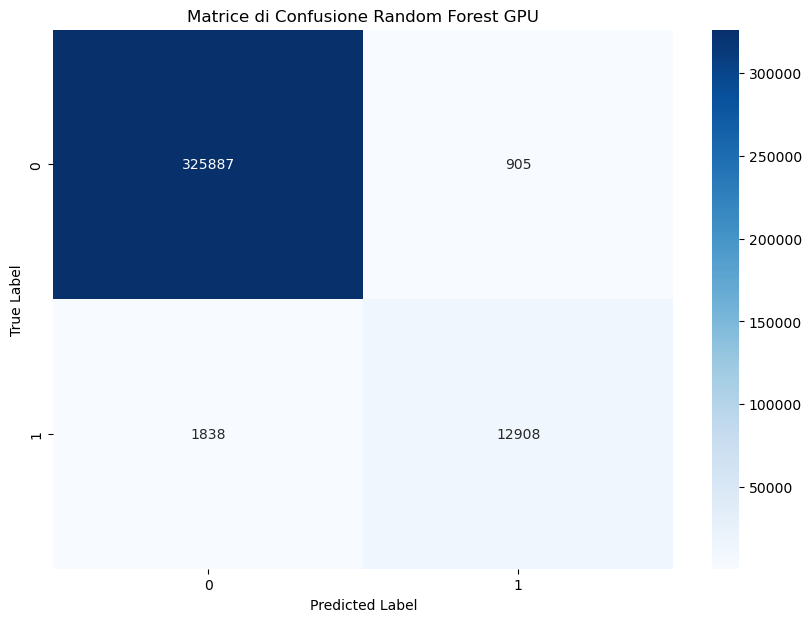

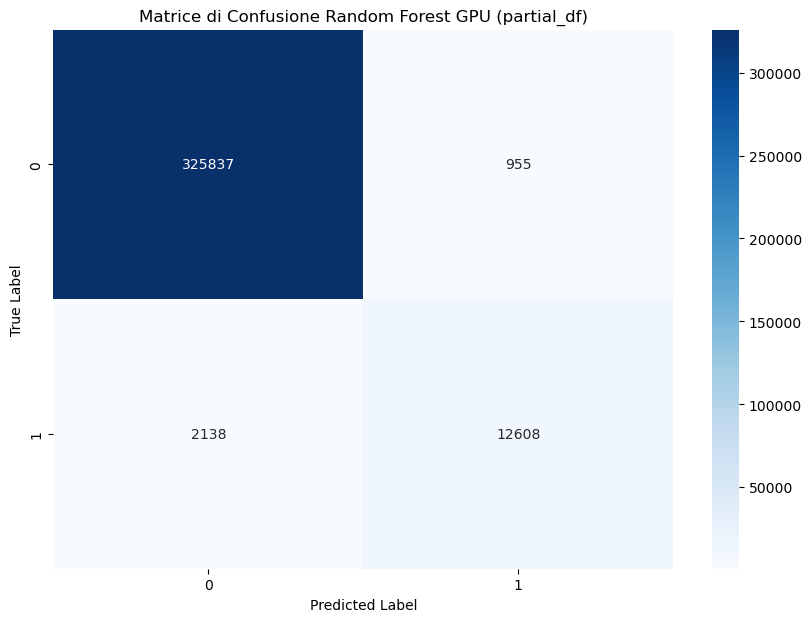

Accuratezza RandomForest GPU: 0.9919687
Accuratezza RandomForest GPU (partial_df): 0.9909439
F1 Score RandomForest GPU: 0.9039532
F1 Score RandomForest GPU (partial_df): 0.8907415


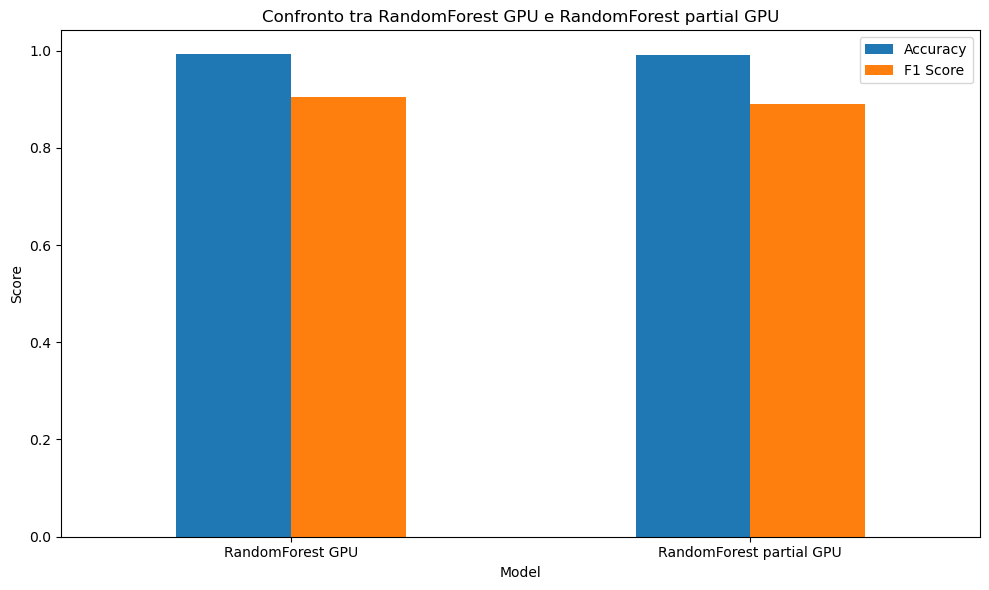

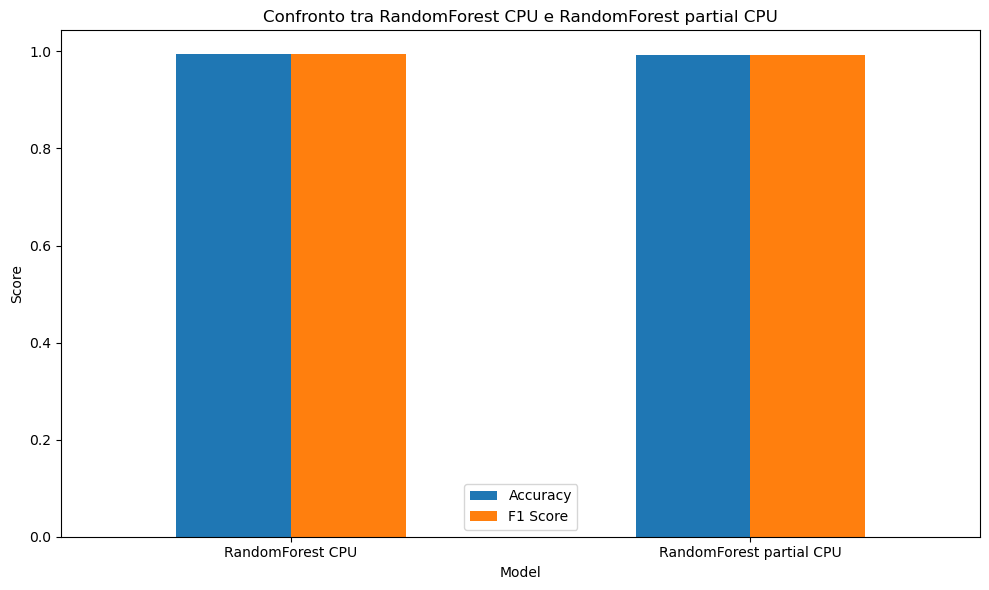

In [30]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_randomforest_gpu, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice di Confusione Random Forest GPU')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_randomforest_gpu_partial, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice di Confusione Random Forest GPU (partial_df)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
f1_score_randomforest_gpu = f1_score(y_test, y_pred_randomforest_gpu)
f1_score_randomforest_gpu_partial = f1_score(y_test_partial, y_pred_randomforest_gpu_partial)
print(f"Accuratezza RandomForest GPU: {accuracy_randomforest_gpu:.7f}")
print(f"Accuratezza RandomForest GPU (partial_df): {accuracy_randomforest_gpu_partial:.7f}")
print(f"F1 Score RandomForest GPU: {f1_score_randomforest_gpu:.7f}")
print(f"F1 Score RandomForest GPU (partial_df): {f1_score_randomforest_gpu_partial:.7f}")

# Confronto tra i due modelli gpu
results = {
    'Model': ['RandomForest GPU', 'RandomForest partial GPU'],
    'Accuracy': [accuracy_randomforest_gpu, accuracy_randomforest_gpu_partial],
    'F1 Score': [f1_score_randomforest_gpu, f1_score_randomforest_gpu_partial]
}
results_df = pd.DataFrame(results)
results_df.set_index('Model', inplace=True)
results_df.plot(kind='bar', figsize=(10, 6))
plt.title('Confronto tra RandomForest GPU e RandomForest partial GPU')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
# Confronto tra i due modelli CPU
results_cpu = {
    'Model': ['RandomForest CPU', 'RandomForest partial CPU'],
    'Accuracy': [accuracy, accuracy_partial],
    'F1 Score': [f1_score(y_test, y_pred, average='weighted'), f1_score(y_test_partial, y_pred_partial, average='weighted')]
}
results_df_cpu = pd.DataFrame(results_cpu)
results_df_cpu.set_index('Model', inplace=True)
results_df_cpu.plot(kind='bar', figsize=(10, 6))
plt.title('Confronto tra RandomForest CPU e RandomForest partial CPU')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
